In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(DESeq2))
suppressMessages(library(BiocParallel))
library(ggplot2)
register(MulticoreParam(8))

In [2]:
rosmap <- readr::read_csv("data/ROSMAP_pseudobulk_by_patient.csv.gz")

New names:
• `` -> `...1`
Rows: 16228 Columns: 425
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): ...1
dbl (424): R1015854, R1028639, R1042011, R1042566, R1067972, R1103580, R1154...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
rosmap_counts <- as.matrix(rosmap[,-1])
rownames(rosmap_counts) <- rosmap[,1] |> dplyr::pull()

In [4]:
rosmap_meta <- readr::read_csv("data/ROSMAP_pseudobulk_metadata.csv.gz")

Rows: 424 Columns: 2
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): individualID, ADdiag3types

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
table(rosmap_meta$ADdiag3types)
rosmap_meta$ADdiag2types <- "nonAD"
rosmap_meta$ADdiag2types[rosmap_meta$ADdiag3types != "nonAD"] <- "hasAD"
table(rosmap_meta$ADdiag2types)


earlyAD  lateAD   nonAD 
    132      73     219 


hasAD nonAD 
  205   219 

In [6]:
if (!all(colnames(rosmap_counts) %in% rosmap_meta$individualID)) {
  stop("Mismatch between the column names.")
}

In [7]:
rosmap_meta <- rosmap_meta[match(colnames(rosmap_counts), rosmap_meta$individualID),]
rosmap_meta$ADdiag2types <- factor(rosmap_meta$ADdiag2types, levels=c("hasAD", "nonAD"))

In [8]:
dds <- DESeqDataSetFromMatrix(
  countData = rosmap_counts,
  colData = rosmap_meta,
  design = ~ ADdiag2types
)

converting counts to integer mode



In [9]:
# Here we keep genes that have at least 10 counts in at least 2 samples
dds_filtered <- dds[rowSums(counts(dds) >= 10) >= 2, ]
dds_filtered <- DESeq(dds_filtered)
res <- results(dds_filtered)
summary(res)
head(res[order(res$padj), ])

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 61 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing




out of 13661 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 173, 1.3%
LFC < 0 (down)     : 158, 1.2%
outliers [1]       : 0, 0%
low counts [2]     : 1325, 9.7%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): ADdiag2types nonAD vs hasAD 
Wald test p-value: ADdiag2types nonAD vs hasAD 
DataFrame with 6 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat      pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
PTPRG    70.38867      -1.570829 0.1287724 -12.19849 3.16641e-34 3.90609e-30
DPYS      2.67585       1.015859 0.1620391   6.26923 3.62847e-10 2.23804e-06
SLC6A6   30.51496      -0.339716 0.0558972  -6.07751 1.22063e-09 5.01921e-06
MYO1E   133.78554      -0.400807 0.0674600  -5.94140 2.82592e-09 8.71513e-06
CACNA1A 178.48106      -0.480966 0.0847316  -5.67635 1.37601e-08 3.18324e-05
CYP2S1    3.65921      -0.507848 0.0897873  -5.65613 1.54827e-08 3.18324e-05

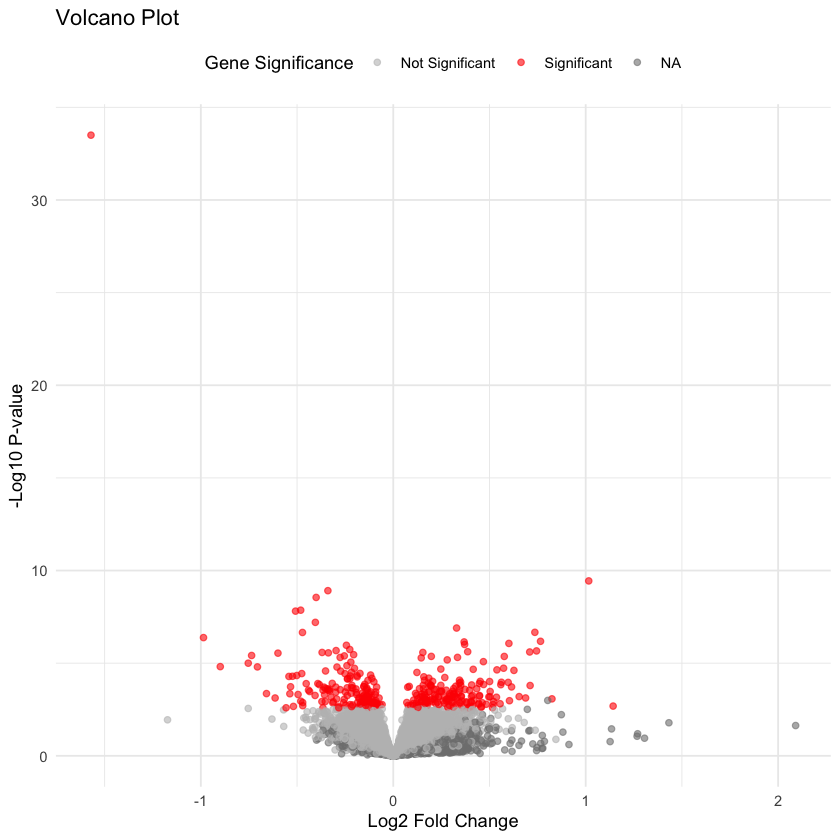

In [10]:
# Add a column to the results indicating significance
res$significant <- ifelse(res$padj < 0.1, "Significant", "Not Significant")

# Convert the results to a data frame for ggplot2
res_df <- as.data.frame(res)

# Create the volcano plot
ggplot(res_df, aes(x = log2FoldChange, y = -log10(pvalue), color = significant)) +
  geom_point(alpha = 0.6, size = 1.5) +
  scale_color_manual(values = c("Significant" = "red", "Not Significant" = "grey")) +
  theme_minimal() +
  labs(title = "Volcano Plot",
       x = "Log2 Fold Change",
       y = "-Log10 P-value",
       color = "Gene Significance") +
  theme(legend.position = "top")

In [11]:
res

log2 fold change (MLE): ADdiag2types nonAD vs hasAD 
Wald test p-value: ADdiag2types nonAD vs hasAD 
DataFrame with 13661 rows and 7 columns
         baseMean log2FoldChange     lfcSE       stat     pvalue      padj
        <numeric>      <numeric> <numeric>  <numeric>  <numeric> <numeric>
NOC2L   12.900532     -0.0377636 0.0577231 -0.6542198   0.512970  0.849577
KLHL17   1.741095     -0.1116822 0.0909703 -1.2276778   0.219568  0.661438
HES4     0.853943      0.1785542 0.1288201  1.3860743   0.165724  0.601995
ISG15    2.776262      0.0146301 0.1680909  0.0870371   0.930642  0.985865
AGRN     3.317343     -0.1334191 0.0968589 -1.3774580   0.168371  0.605016
...           ...            ...       ...        ...        ...       ...
MT-ND4L  19.49470      -0.266054 0.1028139  -2.587723 0.00966127 0.1851956
MT-ND4  362.19758      -0.157665 0.0735720  -2.143008 0.03211245 0.3175200
MT-ND5   65.82062      -0.216680 0.0707938  -3.060716 0.00220809 0.0873215
MT-ND6    1.89265       0.107565 0

In [23]:
# Filter for significant genes with an adjusted p-value < 0.01
sig_genes <- res[which(res$padj < 0.05), ]

# Ensure the results are converted to a data frame
sig_genes_df <- as.data.frame(sig_genes)

# If you have gene symbols stored in the rownames (or as a column), you can extract them
# Assuming rownames are the gene symbols
sig_genes_symbols <- rownames(sig_genes_df)

# Alternatively, if gene symbols are in a column (e.g., gene_symbol):
# sig_genes_symbols <- sig_genes_df$gene_symbol

# Create a data frame with significant genes and their symbols
significant_genes_df <- data.frame(
  GeneSymbol = sig_genes_symbols,
  log2FoldChange = sig_genes_df$log2FoldChange,
  padj = sig_genes_df$padj
)

# Print or view the significant genes
significant_genes_df <- significant_genes_df[order(significant_genes_df$padj), ]
print(significant_genes_df)

    GeneSymbol log2FoldChange         padj
47       PTPRG    -1.57082915 3.906087e-30
114       DPYS     1.01585948 2.238039e-06
44      SLC6A6    -0.33971566 5.019210e-06
174      MYO1E    -0.40080722 8.715134e-06
200    CACNA1A    -0.48096584 3.183245e-05
202     CYP2S1    -0.50784844 3.183245e-05
27     RASGRP3    -0.40486276 1.102764e-04
36      PARD3B     0.32909852 1.953043e-04
82    TNFRSF21     0.73590129 2.712930e-04
90       NHSL1    -0.47179375 2.712930e-04
15      S100A4    -0.98609161 4.668322e-04
30       MEIS1     0.76529762 6.761941e-04
146     TUBA1A     0.36825236 6.761941e-04
31        AFF3     0.60097506 7.551289e-04
72      ZNF608     0.37079116 8.042818e-04
164      PRKCH    -0.24352281 8.324784e-04
143   KIAA1551    -0.22590178 1.321625e-03
14    SELENBP1     0.70917267 1.413703e-03
51        CD96     0.74454662 1.413703e-03
52        HEG1    -0.36981043 1.413703e-03
122      SPIN1     0.15382072 1.413703e-03
158       DGKH    -0.29715745 1.413703e-03
193       A

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 22 rows containing non-finite outside the scale range (`stat_boxplot()`).”


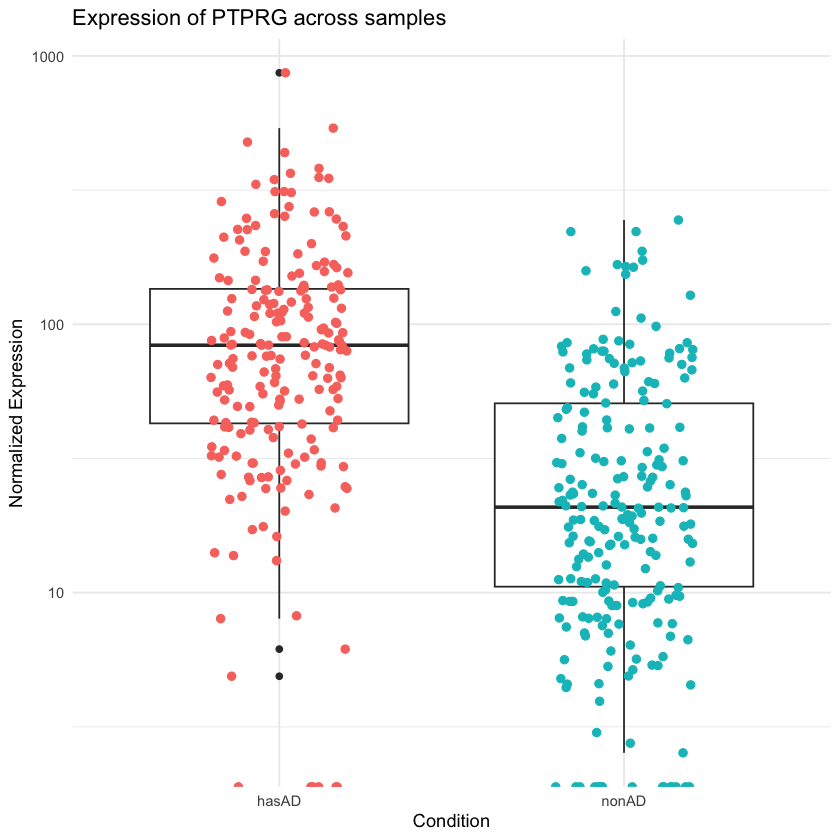

In [26]:
selected_gene <- "PTPRG"
# Extract the normalized counts for the selected gene
norm_counts <- counts(dds_filtered, normalized=TRUE)
gene_counts <- norm_counts[selected_gene, ]

# Convert to a data frame for ggplot
gene_expression_df <- data.frame(
  Sample = colnames(norm_counts),
  Expression = gene_counts,
  Condition = colData(dds)$ADdiag2types
)

# Plot the gene expression across samples
ggplot(gene_expression_df, aes(x = Condition, y = Expression)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 2, aes(color = Condition)) +
  labs(title = paste("Expression of", selected_gene, "across samples"),
       x = "Condition",
       y = "Normalized Expression") +
  theme_minimal() +
  theme(legend.position = "none") +
  scale_y_log10()

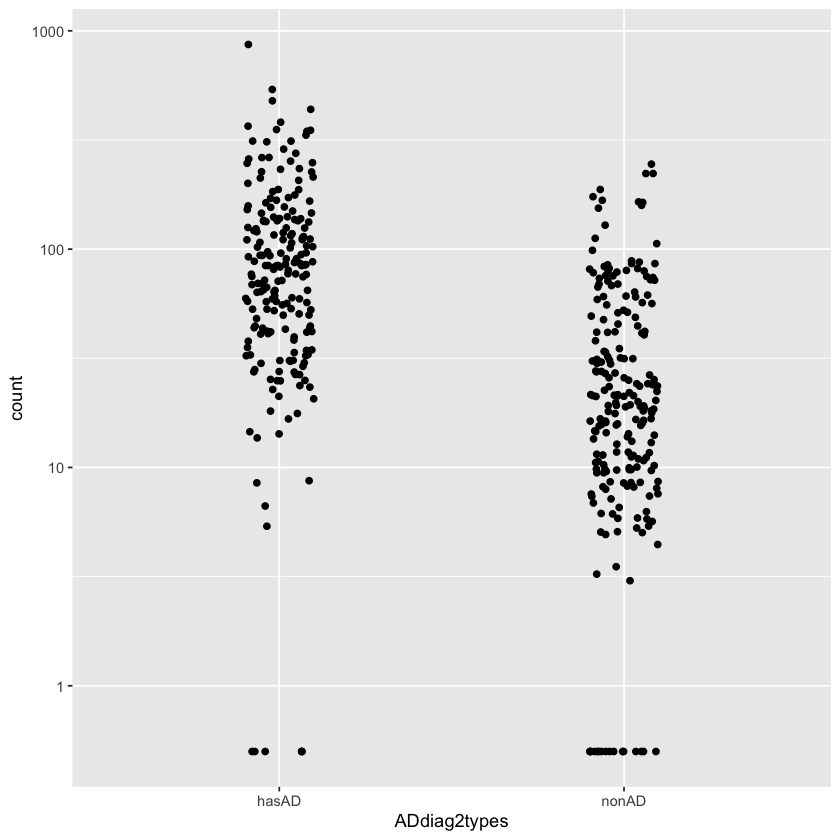

In [15]:
d <- plotCounts(dds, gene="PTPRG", intgroup="ADdiag2types", 
                returnData=TRUE)
ggplot(d, aes(x=ADdiag2types, y=count)) + 
  geom_point(position=position_jitter(w=0.1,h=0)) + 
  scale_y_log10()

using ntop=500 top features by variance



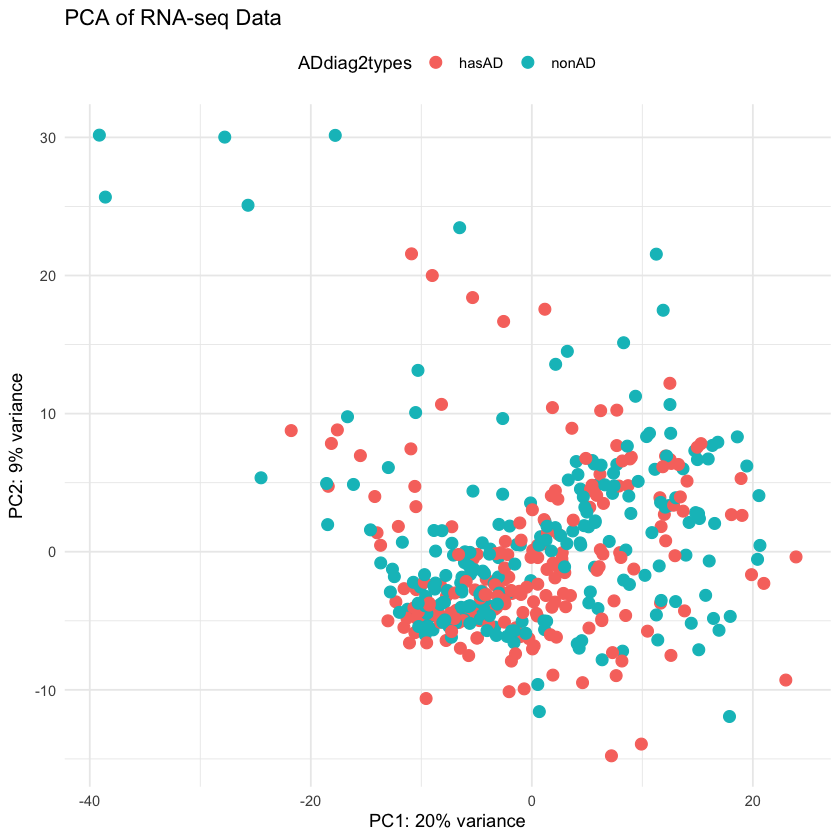

In [16]:
vsd <- vst(dds_filtered, blind = FALSE) 
pca_data <- plotPCA(vsd, intgroup = "ADdiag2types", returnData = TRUE)  # Adjust "condition" to your design variable

# Calculate the percentage of variance explained by each principal component
percentVar <- round(100 * attr(pca_data, "percentVar"))

# Create the PCA plot using ggplot2
ggplot(pca_data, aes(x = PC1, y = PC2, color = ADdiag2types)) +  # Adjust "condition" to your design variable
  geom_point(size = 3) +
  labs(title = "PCA of RNA-seq Data",
       x = paste0("PC1: ", percentVar[1], "% variance"),
       y = paste0("PC2: ", percentVar[2], "% variance")) +
  theme_minimal() +
  theme(legend.position = "top")

In [24]:
significant_genes_df

,GeneSymbol,log2FoldChange,padj
,<chr>,<dbl>,<dbl>
47,PTPRG,-1.5708291,3.906087e-30
114,DPYS,1.0158595,2.238039e-06
44,SLC6A6,-0.3397157,5.019210e-06
174,MYO1E,-0.4008072,8.715134e-06
200,CACNA1A,-0.4809658,3.183245e-05
202,CYP2S1,-0.5078484,3.183245e-05
27,RASGRP3,-0.4048628,1.102764e-04
36,PARD3B,0.3290985,1.953043e-04
82,TNFRSF21,0.7359013,2.712930e-04


In [30]:
cat(paste0(significant_genes_df[significant_genes_df$log2FoldChange > 0,]$GeneSymbol, 
           collapse= "\n"), file="example_genes_lowAD.txt")
cat(paste0(significant_genes_df[significant_genes_df$log2FoldChange < 0,]$GeneSymbol, 
           collapse= "\n"), file="example_genes_highAD.txt")